<font color='red'> <h1><center> Premiere TS (iloc 0, Liste2): Valeurs utiles : </h1> </font> || <h2> <center> U = 2.15 || h = 100 || Tension = 32100 </h2>

<font color='red'> <h1><center> Importation modules </h1> </font>

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import yaml
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
import sys
sys.path.append("..")
from uvsw_part import simulation
import copy
from math import e

<font color='red'> <h1> <center>Chargement fichier config | Verification variables </h1> </font>

In [24]:
data_list = pd.read_csv("../data/List2.txt" , delim_whitespace=True)
data_list.head(10)

,nc,md,U[m/s],d[m],m[kg/m],L[m],H[N],Nt,Dt[s],tf[s],ymax[m],filename
0,1,1,0.9,0.025,1.57,1,500,18015,0.0004,7.2060,7.681950e-08,Data1.1.bin
1,2,1,0.9,0.025,1.57,1,500,100000,0.0004,40.0000,2.049360e-04,Data1.2.bin
2,3,1,0.9,0.025,1.57,1,500,38068,0.0004,15.2272,2.684940e-05,Data1.3.bin
3,4,1,0.9,0.025,1.57,1,500,26408,0.0004,10.5632,1.799240e-05,Data1.4.bin
4,5,1,0.9,0.025,1.57,1,500,42788,0.0004,17.1152,1.771030e-05,Data1.5.bin
5,6,1,0.9,0.025,1.57,1,500,10000,0.0004,4.0000,3.284350e-06,Data1.6.bin
6,7,1,0.9,0.025,1.57,1,2000,100000,0.0004,40.0000,3.295740e-04,Data1.7.bin
7,8,1,0.9,0.025,1.57,1,2000,100000,0.0004,40.0000,1.749020e-03,Data1.8.bin
8,9,1,0.9,0.025,1.57,1,2000,100000,0.0004,40.0000,1.863200e-03,Data1.9.bin
9,10,1,0.9,0.025,1.57,1,2000,53081,0.0004,21.2324,1.458650e-03,Data1.10.bin


In [4]:
def root_mean_squared_error(y_test,y_pred):
    """
    Calcule le root_mean_squared_error (RMSE)
    
    Paramètres
    ----------
    y_test
    y_pred
    
    Return
    ------
    
    RMSE
    

    """
    return np.sqrt(mean_squared_error(y_test,y_pred))

<h1> <center> Test d'une <u> unique série </u> temporelle avec des valeurs différentes de h </center> </h1>

################ h value: 100 ################
h value:  100.0  u value:  2.15  tension value:  32100.0
tf value  13.3264


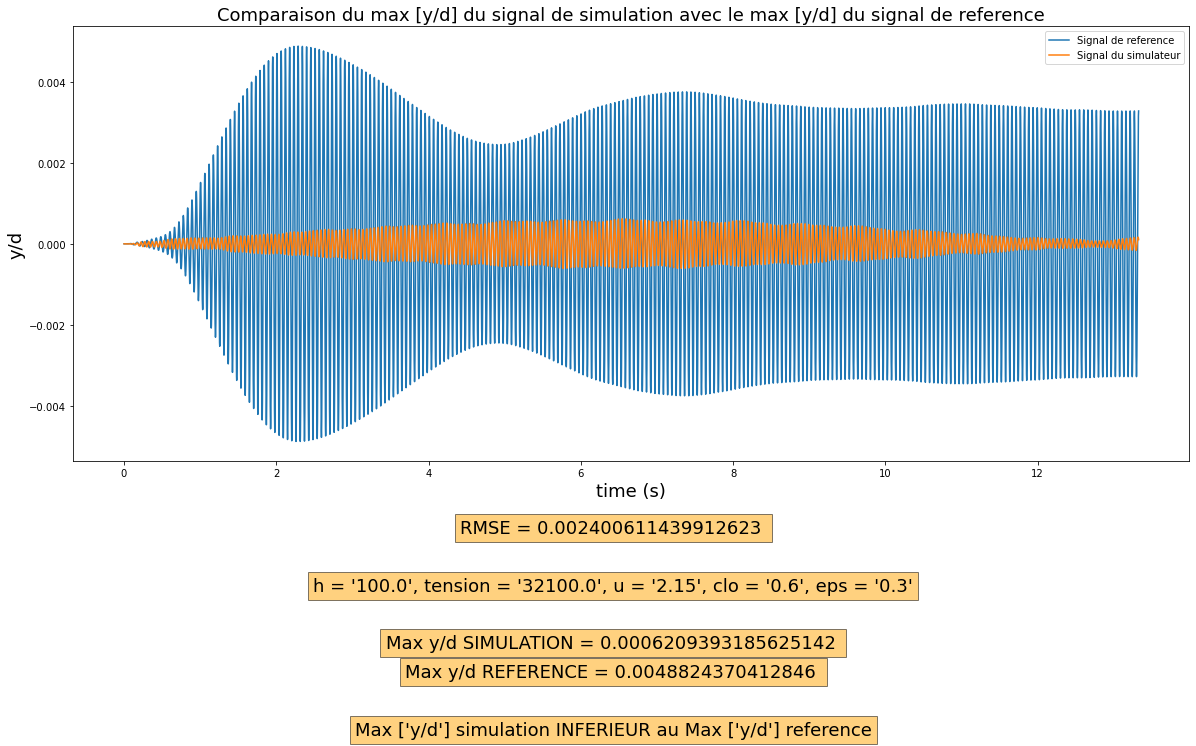

R2 :  -0.013437086811246335
MSE :  5.762935285439357e-06


In [25]:
h_list = [100,102]
tension = 32100
u = 2.15
clo = 0.6
eps = 0.3
set_params = data_list.iloc[0,:]

ref = pd.read_csv("../data/csv/Liste2/graph{}.csv".format(set_params["nc"]))

for h_value in h_list: 

    print("################ h value: {} ################".format(h_value))
    cfg = yaml.safe_load(open('../data/config/example.in.yaml', 'r'))

    #cfg["cable"]["h"] = float(set_params["H[N]"])
    cfg["cable"]["h"] = float(h_value)

    cfg["simulation"]["tf"] = float(set_params["tf[s]"])

    cfg["cable"]["tension"] = float(tension)
    #cfg["cable"]["tension"] = float(T_value)

    #cfg["wakeosc"]["u"] = float(u_value)
    #cfg["wakeosc"]["u"] = float(set_params["U[m/s]"])
    cfg["wakeosc"]["u"] = u
    cfg["wakeosc"]["cl0"]= float(clo)
    cfg["wakeosc"]["eps"]= float(eps)

    cfg["simulation"]["dt"] = cfg["simulation"]["tf"] / len(ref) # MODIF DT
    cfg["simulation"]["dr"] = cfg["simulation"]["tf"] / len(ref) # MODIF DR



    print("h value: ", cfg["cable"]["h"], " u value: ", cfg["wakeosc"]["u"]," tension value: ",cfg["cable"]["tension"])
    print("tf value ", cfg["simulation"]["tf"])
    dfy, _ = simulation.run_cable_wakeosc(cfg)
    
    mse = mean_squared_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    rmse = root_mean_squared_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    mea = mean_absolute_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    
    max_ref = max(ref['y/d'])
    
    max_sim = max((dfy['s=0.250']/0.025).values[:-1])
    
    compare_text = ""
    
    if(max_sim < max_ref):
        compare_text = "Max ['y/d'] simulation INFERIEUR au Max ['y/d'] reference"
    if(max_sim > max_ref):
        compare_text = "Max ['y/d'] simulation SUPERIEUR au Max ['y/d'] reference"
    if(max_sim == max_ref):
        compare_text = "Max ['y/d'] simulation EGAL au Max ['y/d'] reference"
        
        
    

    mse_text= "MSE = %s " % mse
    rmse_text = "RMSE = %s " % rmse
    mea_text = "MEA = %s " % mea
    max_ref = "Max y/d REFERENCE = %s " % max_ref
    max_sim = "Max y/d SIMULATION = %s " % max_sim

    #print(r2_score(ref['y/d'],simulation['y/d'][:-1]))
    #print(mean_squared_error(ref['y/d'],simulation['y/d'][:-1])) # Moi qui ai testé

    plt.figure(figsize = (20,8))
    plt.plot(ref['time'], ref['y/d'], label = "Signal de reference")
    plt.plot(dfy.index, dfy['s=0.250']/0.025, label = "Signal du simulateur")
    plt.xlabel('time (s)',fontsize=18)
    plt.ylabel('y/d',fontsize=18)

    #plt.figtext(0.5, 0.00, mse_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, 0.00, rmse_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    #plt.figtext(0.5, -0.10, mea_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})


    plt.figtext(0.5, -0.10, "h = '{0}', tension = '{1}', u = '{2}', clo = '{3}', eps = '{4}'".format(cfg['cable']['h'],cfg['cable']['tension'],cfg['wakeosc']['u'],cfg["wakeosc"]["cl0"],cfg["wakeosc"]["eps"]), ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    
    plt.figtext(0.5, -0.20, max_sim, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.25, max_ref, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    
    plt.figtext(0.5, -0.35, compare_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})



    
    title = "Comparaison du max [y/d] du signal de simulation avec le max [y/d] du signal de reference en modifiant h"
    plt.title(title,fontsize=18)

    plt.legend()
    plt.show() 
    #print(r2_score(ref['y/d'],dfy['s=0.250']/0.025[:-1]))
    #print(mean_squared_error(ref['y/d'],dfy['s=0.250']/0.025[:-1])) # Moi qui ai testé

    print("R2 : ",r2_score(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1]))
    print("MSE : ",mean_squared_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])) # Correct


